In [1]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
import matplotlib
import nltk
import numpy as np
# Let me see the full string
pd.options.display.max_colwidth = 100


## To do -
1) BERT
2) Map sentences to topics, get some sort of score - done
4) Bifurcate respones into good and bad. Find word patterns in good and bad.
 

In [385]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import string
from collections import defaultdict


In [168]:
raw_data = pd.read_csv(
    "C:\\Users\\g654674\\OneDrive - General Mills\\Work_OneDrive\\PGI\\Text Analytics\\Remarkability Test\\remarkability_raw_data.csv", encoding='latin1')
docs = raw_data['op_oe'].str.lower()


### Topic categorization support

In [169]:
# Remove Stop Words
stop_words = set(stopwords.words('english'))

stop_remove_docs = []
for doc in docs:
    word_tokens = word_tokenize(doc)
    # converts the words in word_tokens to lower case and then checks whether
    # they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    # with no lower case conversion
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    filtered_sentence = " ".join(filtered_sentence)

    stop_remove_docs.append(filtered_sentence)


In [329]:
# Lemmatize
lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1


def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


lemmatized_docs = []

for sentence in stop_remove_docs:
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # >[('the', 'DT'), ('cat', 'NN'), ('is', 'VBZ'), ('sitting', 'VBG'), ('with', 'IN'),
    # ('the', 'DT'), ('bats', 'NNS'), ('on', 'IN'), ('the', 'DT'), ('striped', 'JJ'),
    # ('mat', 'NN'), ('under', 'IN'), ('many', 'JJ'), ('flying', 'VBG'), ('geese', 'JJ')]

    # As you may have noticed, the above pos tags are a little confusing.

    # we use our owordnet pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    # >[('the', None), ('cat', 'n'), ('is', 'v'), ('sitting', 'v'), ('with', None),
    # ('the', None), ('bats', 'n'), ('on', None), ('the', None), ('striped', 'a'),
    # ('mat', 'n'), ('under', None), ('many', 'a'), ('flying', 'v'), ('geese', 'a')]

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    lemmatized_docs.append(lemmatized_sentence)


In [202]:
# Ind list lemmatization
appearance_ls = ['functionality', 'messy', 'dough on hands',
                 'easy to handle', 'difficult to handle']
pos_tagged = nltk.pos_tag(appearance_ls)
wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
appearance_ls = []
for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, append the token as is
        appearance_ls.append(word)
    else:
        # else use the tag to lemmatize the token
        appearance_ls.append(lemmatizer.lemmatize(word, tag))

print(appearance_ls)


['functionality', 'messy', 'dough on hands', 'easy to handle', 'difficult to handle']


In [323]:
# Implementing fuzzy lookup
# Create list of attributes we want to check
# appearance_ls = ['appearance','color','bright','dull','size','large','small','dough ','chocolate chips','baked','golden browordnet','browordnet ','light','dark','cracking','big']
appearance_ls = ['appearance', 'appear', 'look', 'color', 'bright', 'dull', 'size', 'large', 'small',
                 'dough ', 'chocolate chips', 'bake', 'golden brown', 'brown ', 'light', 'dark', 'crack', 'big']

# texture_ls = ['texture ','moist','dry','chewy','crunchy','crispy','soft','hard','wet','toothpack','teeth','thick','thickness','edge','melt in your mouth','crumbly']
texture_ls = ['texture', 'moist', 'dry', 'chewy', 'crunchy', 'crispy', 'soft', 'hard',
              'wet', 'toothpack', 'teeth', 'thick', 'thickness', 'edge', 'melt in your mouth', 'crumbly']

# flavor_ls = ['flavor','chocolate chip','sweetness', 'sweet','too sweet','raw cookie dough','chocolate flavor','chip flavor','semi sweet','balanced','aroma','brown sweet']
flavor_ls = ['flavor', 'taste', 'tasted', 'bitter', 'chocolate chip', 'sweetness', 'delicious', 'yummy', 'sweet',
             'too sweet', 'raw cookie dough', 'chocolate flavor', 'chip flavor', 'semi sweet', 'balance', 'aroma', 'brown sweet']

pi_ls = ['purchase intent', 'price', 'value',
         'cost', 'cheap', 'number', 'size']

# packaging_ls = ['packaging','cute','blue','dough boy','fun','boring','delicious','yummy','easy to open','difficult to open','yellow','large','small','smaller']
packaging_ls = ['package', 'cute', 'blue', 'fun', 'bore' 'easy to open',
                'difficult to open', 'yellow', 'large', 'small']

function_ls = ['functionality', 'messy',
               'easy to handle', 'difficult to handle']


In [404]:
def fuzzy_lookup(responses_ls, lookup_list, threshold):
    matched_list = []
    for q in responses_ls:
        if(process.extractOne(q, lookup_list, scorer=fuzz.partial_token_set_ratio)[1] > threshold):
            matched_list.append(process.extractOne(
                q, lookup_list, scorer=fuzz.partial_token_set_ratio))
        else:
            matched_list.append("")
    return matched_list


In [325]:
appearance_res_ls = fuzzy_lookup(lemmatized_docs, appearance_ls, 80)
texture_res_ls = fuzzy_lookup(lemmatized_docs, texture_ls, 80)
flavor_res_ls = fuzzy_lookup(lemmatized_docs, flavor_ls, 80)
pi_res_ls = fuzzy_lookup(lemmatized_docs, pi_ls, 80)
packaging_res_ls = fuzzy_lookup(lemmatized_docs, packaging_ls, 80)
function_res_ls = fuzzy_lookup(lemmatized_docs, function_ls, 80)

fuzzy_res_df = pd.DataFrame({'op_oe': docs, 'reduced_sentence': lemmatized_docs, 'Appearance': appearance_res_ls, 'Texture': texture_res_ls,
                             'Flavor': flavor_res_ls, 'purchase_intent': pi_res_ls, 'Packaging': packaging_res_ls, 'Functionality': function_res_ls}, index=df.index)
fuzzy_res_df['appearance_match'], fuzzy_res_df['appearance_score'] = fuzzy_res_df.Appearance.str
fuzzy_res_df['texture_match'], fuzzy_res_df['texture_score'] = fuzzy_res_df.Texture.str
fuzzy_res_df['flavor_match'], fuzzy_res_df['flavor_score'] = fuzzy_res_df.Flavor.str
# fuzzy_res_df['purchase_intent_match'], fuzzy_res_df['purchase_intent_score'] = fuzzy_res_df.purchase_intent.str
fuzzy_res_df['packaging_match'], fuzzy_res_df['packaging_score'] = fuzzy_res_df.Packaging.str
fuzzy_res_df['functionality_match'], fuzzy_res_df['functionality_score'] = fuzzy_res_df.Functionality.str


In [326]:
fuzzy_res_df.to_clipboard(index=False)


In [333]:
def tokenize(text):
    split = word_tokenize(text)
    return split


def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct


fuzzy_res_df['tokenized_lemmatized_no_punc'] = fuzzy_res_df['reduced_sentence'].apply(
    lambda x: remove_punctuation(x))

fuzzy_res_df['tokenized_lemmatized'] = fuzzy_res_df['tokenized_lemmatized_no_punc'].apply(
    lambda x: tokenize(x.lower()))


In [ ]:
fuzzy_res_df.to_clipboard(index=False)


### Functionality Calculation Support

In [350]:
# get word freqeuncy count for functionatlity
freq_df = pd.read_excel(
    "C:\\Users\\g654674\\OneDrive - General Mills\\Work_OneDrive\\PGI\\Text Analytics\\Remarkability Test\\remarkability_test_analysis.xlsx", sheet_name='functionality_pref')


In [351]:
def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct


In [352]:
freq_df['reduced_sentence_no_punc'] = freq_df['reduced_sentence'].apply(
    lambda x: remove_punctuation(x))


In [353]:
grouped_df = freq_df.groupby('overall_preference')


In [354]:
nestle = grouped_df.get_group('nestle')
pillsbury = grouped_df.get_group('pillsbury')


In [355]:
nestle['reduced_sentence_no_punc'].str.lower().str.split(
    expand=True).stack().value_counts().head(10).reset_index()


,index,0
0,easy,5
1,well,4
2,pillsbury,3
3,nestle,3
4,taste,3
5,soft,2
6,cookie,2
7,chip,2
8,chocolate,2
9,warm,2


In [356]:
pillsbury['reduced_sentence_no_punc'].str.lower().str.split(
    expand=True).stack().value_counts().head(10).reset_index()


,index,0
0,cookie,24
1,pillsbury,17
2,easy,17
3,taste,13
4,one,11
5,apart,10
6,well,10
7,nestle,10
8,like,9
9,package,7


### Packaging Support

In [129]:
# https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
# https://github.com/seatgeek/thefuzz
resp = 'more chewy and more flavor'
# intersection of strings and then sort
process.extract(resp, flavor_ls, limit=1, scorer=fuzz.token_set_ratio)


[('flavor', 100)]

In [378]:
package_df = pd.read_excel(
    "C:\\Users\\g654674\\OneDrive - General Mills\\Work_OneDrive\\PGI\\Text Analytics\\Remarkability Test\\remarkability_test_analysis.xlsx", sheet_name='pp_categorization')
# docs = package_df['pp_oe'].str.lower()


In [380]:
def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct


package_df['pp_oe_no_punc'] = package_df['pp_oe'].apply(
    lambda x: remove_punctuation(x))


In [381]:
def tokenize(text):
    split = word_tokenize(text)
    return split


package_df['pp_oe_no_punc_token'] = package_df['pp_oe_no_punc'].apply(
    lambda x: tokenize(x.lower()))


In [383]:
stop_words = set(stopwords.words("english"))


def remove_stopwords(text):
    filtered_list = [word for word in text if word.casefold()
                     not in stop_words]
    return filtered_list


package_df['pp_oe_no_punc_token_no_stop'] = package_df['pp_oe_no_punc_token'].dropna(
).apply(lambda x: remove_stopwords(x))


In [388]:
from nltk import word_tokenize, pos_tag
tag_map = defaultdict(lambda: wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV

lmtzr = WordNetLemmatizer()


def lemmatize_func(tokens):
    lem_list = []
    for token, tag in pos_tag(tokens):
        lem_list.append(lmtzr.lemmatize(token, tag_map[tag[0]]))
    return lem_list


package_df['pp_oe_no_punc_token_no_stop_lemm'] = package_df['pp_oe_no_punc_token_no_stop'].dropna(
).apply(lambda x: lemmatize_func(x))


In [390]:
combined_ls = []
for id, rows in package_df['pp_oe_no_punc_token_no_stop_lemm'].iteritems():
    for items in rows:
        combined_ls.append((items))


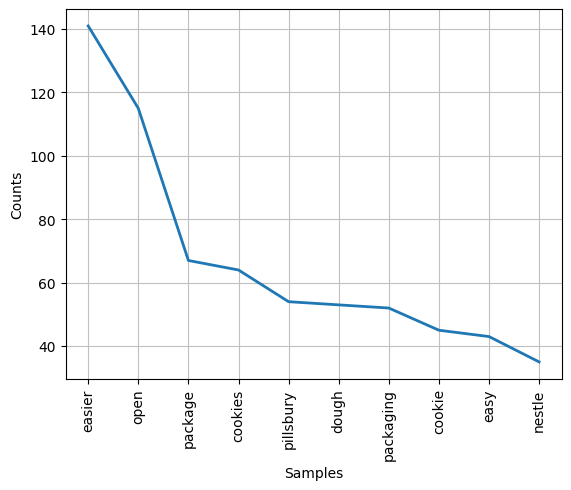

<Axes: xlabel='Samples', ylabel='Counts'>

In [392]:
fd = nltk.FreqDist(combined_ls)
fd.plot(10, cumulative=False)


In [394]:
lem_combined_ls = []
for id, rows in package_df['pp_oe_no_punc_token_no_stop_lemm'].iteritems():
    for items in rows:
        lem_combined_ls.append((items))


In [395]:
coll_text = nltk.Text(lem_combined_ls)
coll_text.collocations()


easy open; cookie dough; break apart; toll house; use scissors;
already separate; cooky come; wish resealable; cooky easier; cookie
sheet; much easy; dough boy; almost identical; cut top; along top;
bright yellow; boy front; catch eye; see direction; cardboard insert


In [397]:
text = nltk.Text(combined_ls)
finder = nltk.collocations.BigramCollocationFinder.from_words(text)
finder.ngram_fd.most_common(5)


[(('easier', 'open'), 49),
 (('cookie', 'dough'), 30),
 (('easy', 'open'), 22),
 (('break', 'apart'), 12),
 (('package', 'easier'), 12)]

### Expectations open end

In [441]:
expec_df = pd.read_excel(
    "C:\\Users\\g654674\\OneDrive - General Mills\\Work_OneDrive\\PGI\\Text Analytics\\Remarkability Test\\remarkability_test_analysis.xlsx", sheet_name='me_opportunity')
docs = expec_df['e_oe'].str.lower()


In [442]:
# Remove Stop Words
stop_words = set(stopwords.words('english'))

stop_remove_docs = []
for doc in docs:
    word_tokens = word_tokenize(doc)
    # converts the words in word_tokens to lower case and then checks whether
    # they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    # with no lower case conversion
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    filtered_sentence = " ".join(filtered_sentence)

    stop_remove_docs.append(filtered_sentence)


In [443]:
# Lemmatize
lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1


def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


lemmatized_docs = []

for sentence in stop_remove_docs:
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # >[('the', 'DT'), ('cat', 'NN'), ('is', 'VBZ'), ('sitting', 'VBG'), ('with', 'IN'),
    # ('the', 'DT'), ('bats', 'NNS'), ('on', 'IN'), ('the', 'DT'), ('striped', 'JJ'),
    # ('mat', 'NN'), ('under', 'IN'), ('many', 'JJ'), ('flying', 'VBG'), ('geese', 'JJ')]

    # As you may have noticed, the above pos tags are a little confusing.

    # we use our owordnet pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    # >[('the', None), ('cat', 'n'), ('is', 'v'), ('sitting', 'v'), ('with', None),
    # ('the', None), ('bats', 'n'), ('on', None), ('the', None), ('striped', 'a'),
    # ('mat', 'n'), ('under', None), ('many', 'a'), ('flying', 'v'), ('geese', 'a')]

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    lemmatized_docs.append(lemmatized_sentence)


In [444]:
# Implementing fuzzy lookup
# Create list of attributes we want to check
# appearance_ls = ['appearance','color','bright','dull','size','large','small','dough ','chocolate chips','baked','golden browordnet','browordnet ','light','dark','cracking','big']
appearance_ls = ['appearance', 'appear', 'look', 'color', 'bright', 'dull', 'size', 'large', 'small',
                 'dough ', 'chocolate chips', 'bake', 'golden brown', 'brown ', 'light', 'dark', 'crack', 'big']

# texture_ls = ['texture ','moist','dry','chewy','crunchy','crispy','soft','hard','wet','toothpack','teeth','thick','thickness','edge','melt in your mouth','crumbly']
texture_ls = ['texture', 'moist', 'dry', 'chewy', 'crunchy', 'crispy', 'soft', 'hard',
              'wet', 'toothpack', 'teeth', 'thick', 'thickness', 'edge', 'melt in your mouth', 'crumbly']

# flavor_ls = ['flavor','chocolate chip','sweetness', 'sweet','too sweet','raw cookie dough','chocolate flavor','chip flavor','semi sweet','balanced','aroma','brown sweet']
flavor_ls = ['flavor', 'taste', 'tasted', 'bitter', 'chocolate chip', 'sweetness', 'delicious', 'yummy', 'sweet',
             'too sweet', 'raw cookie dough', 'chocolate flavor', 'chip flavor', 'semi sweet', 'balance', 'aroma', 'brown sweet']

pi_ls = ['purchase intent', 'price', 'value',
         'cost', 'cheap', 'number', 'size']

# packaging_ls = ['packaging','cute','blue','dough boy','fun','boring','delicious','yummy','easy to open','difficult to open','yellow','large','small','smaller']
packaging_ls = ['package', 'cute', 'blue', 'fun', 'bore' 'easy to open',
                'difficult to open', 'yellow', 'large', 'small']

function_ls = ['functionality', 'messy',
               'easy to handle', 'difficult to handle']


In [445]:
appearance_res_ls = fuzzy_lookup(lemmatized_docs, appearance_ls, 80)
texture_res_ls = fuzzy_lookup(lemmatized_docs, texture_ls, 80)
flavor_res_ls = fuzzy_lookup(lemmatized_docs, flavor_ls, 80)
pi_res_ls = fuzzy_lookup(lemmatized_docs, pi_ls, 80)
packaging_res_ls = fuzzy_lookup(lemmatized_docs, packaging_ls, 80)
function_res_ls = fuzzy_lookup(lemmatized_docs, function_ls, 80)

fuzzy_res_df = pd.DataFrame({'e_oe': docs, 'reduced_sentence': lemmatized_docs, 'Appearance': appearance_res_ls, 'Texture': texture_res_ls,
                             'Flavor': flavor_res_ls, 'purchase_intent': pi_res_ls, 'Packaging': packaging_res_ls, 'Functionality': function_res_ls}, index=df.index)
fuzzy_res_df['appearance_match'], fuzzy_res_df['appearance_score'] = fuzzy_res_df.Appearance.str
fuzzy_res_df['texture_match'], fuzzy_res_df['texture_score'] = fuzzy_res_df.Texture.str
fuzzy_res_df['flavor_match'], fuzzy_res_df['flavor_score'] = fuzzy_res_df.Flavor.str
# fuzzy_res_df['purchase_intent_match'], fuzzy_res_df['purchase_intent_score'] = fuzzy_res_df.purchase_intent.str
fuzzy_res_df['packaging_match'], fuzzy_res_df['packaging_score'] = fuzzy_res_df.Packaging.str
fuzzy_res_df['functionality_match'], fuzzy_res_df['functionality_score'] = fuzzy_res_df.Functionality.str


In [446]:
from transformers import pipeline

# sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")
docs_ls = list(docs)
sen_ls = sentiment_pipeline(docs_ls)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [447]:
sentiment = []
score_ls = []
for sen in sen_ls:
    sentiment.append(sen['label'])
    score_ls.append(sen['score'])


In [448]:
fuzzy_res_df['sentiment'] = sentiment
fuzzy_res_df['sentiment_score'] = score_ls


In [449]:
fuzzy_res_df.to_clipboard(index=False)


In [452]:
expec_df = pd.read_excel(
    "C:\\Users\\g654674\\OneDrive - General Mills\\Work_OneDrive\\PGI\\Text Analytics\\Remarkability Test\\remarkability_test_analysis.xlsx", sheet_name='me_highlights')


In [487]:
pils_df = expec_df[expec_df['evaluated'] == 'pilsbury']
nestle_df = expec_df[expec_df['evaluated'] == 'nestle']


In [489]:
pils_df[(pils_df['exceeded'] == 'yes') & (pils_df['Appearance'] == 'yes')][[
    'evaluated', 'e_oe', 'Appearance', 'sentiment', 'sentiment_score']].to_clipboard(index=False)


In [490]:
nestle_df[(nestle_df['exceeded'] == 'yes') & (nestle_df['Appearance'] == 'yes')][[
    'evaluated', 'e_oe', 'Appearance', 'sentiment', 'sentiment_score']].to_clipboard(index=False)


In [498]:
pils_df[(pils_df['did_not_meet'] == 'yes') & (pils_df['Appearance'] == 'yes')][[
    'evaluated', 'e_oe', 'Appearance', 'sentiment', 'sentiment_score']].to_clipboard(index=False)


In [499]:
nestle_df[(nestle_df['did_not_meet'] == 'yes') & (nestle_df['Appearance'] == 'yes')][[
    'evaluated', 'e_oe', 'Appearance', 'sentiment', 'sentiment_score']].to_clipboard(index=False)


In [493]:
pils_df[pils_df['did_not_meet'] == 'yes'].count()


evaluated              5
exceeded               5
met                    5
did_not_meet           5
e_oe                   5
reduced_sentence       5
Appearance             3
Texture                0
Flavor                 4
purchase_intent        0
Packaging              2
Functionality          0
appearance_match       3
appearance_score       3
texture_match          0
texture_score          0
flavor_match           4
flavor_score           4
packaging_match        2
packaging_score        2
functionality_match    0
functionality_score    0
sentiment              5
sentiment_score        5
dtype: int64

In [485]:
nestle_df[nestle_df['did_not_meet'] == 'yes'].count()


evaluated              12
exceeded               12
met                    12
did_not_meet           12
e_oe                   12
reduced_sentence       12
Appearance              6
Texture                 3
Flavor                 10
purchase_intent         0
Packaging               6
Functionality           1
appearance_match        6
appearance_score        6
texture_match           3
texture_score           3
flavor_match           10
flavor_score           10
packaging_match         6
packaging_score         6
functionality_match     1
functionality_score     1
sentiment              12
sentiment_score        12
dtype: int64

### Other

In [370]:
new_docs = []
for elem in docs:
    new_elem = elem.replace('pillsbury', '')
    new_elem = new_elem.replace('pilsbury', '')
    new_elem = new_elem.replace('nestle', '')
    new_elem = new_elem.replace('nestle tollhouse', '')
    new_docs.append(new_elem)


In [371]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model_rt = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model_rt.fit_transform(new_docs)


In [372]:
topic_model_rt.get_topic_info()


,Topic,Count,Name
0,-1,3,-1_ripped_tollhouse_written_messed
1,0,95,0_open_packaging_easier_package
2,1,93,1_cookies_dough_easier_cookie
3,2,36,2_open_easier_easy_opens


In [373]:
topic_mapped_df = topic_model_rt.get_document_info(new_docs)


In [376]:
topic_mapped_df['og_document'] = docs
topic_mapped_df.to_clipboard(index=False)


In [375]:
df = pd.DataFrame({"Document": docs, "Topic": topics})


In [60]:
df


,Document,Topic
0,I like the taste of the chocolate better with ...,0
1,The taste is better to me. The cookie seems go...,1
2,I like the Pillsbury Chocolate Chip Cookie Dou...,0
3,They have more chocolate chips and are a littl...,0
4,Nestle cookie tastes more like homemade. Nes...,3
...,...,...
222,Enjoy the flavor and texture more,2
223,It just tasted better. It also had more chocol...,1
224,It has a little bit of a better taste not as s...,1
225,More chocolatety taste say my 10 and 7 year ...,1


In [10]:
docs = fetch_20newsgroups(subset='all',  remove=(
    'headers', 'footers', 'quotes'))['data']


In [11]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)


In [14]:
topic_model.get_topic_info()


,Topic,Count,Name
0,-1,6660,-1_to_the_of_is
1,0,1829,0_game_team_games_he
2,1,574,1_key_clipper_chip_encryption
3,2,526,2_idjits_ites_cheek_dancing
4,3,470,3_israel_israeli_jews_arab
...,...,...,...
221,220,10,220_law_jesus_god_worship
222,221,10,221_fat_weight_muscle_pills
223,222,10,222_purchased_projects_fluke_paperback
224,223,10,223_keyboard_rsi_exercises_typing
